#2) RNNs

##a) Transforming features/targets from 2D vectors to 3D tensors

In [ ]:
#!pip install optuna #this is for parameter search
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Masking
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


convert 2D gamestate vectors into 3D gamestate tensors using padding

In [ ]:
max_len = 704  #Trundicating to 704

def pad_sequences(seq, max_len, pad_value=-1):
    # If the sequence is longer than max_len, truncate it
    if len(seq) > max_len:
        seq = seq[:max_len]
    # If the sequence is shorter than max_len, pad with vectors of pad_value
    padded_seq = seq + [np.full(85, pad_value)] * (max_len - len(seq))
    return np.array(padded_seq)

final_df['padded_sequences'] = final_df['board_states'].apply(lambda seq: pad_sequences(seq, max_len))

sequence_tensor = np.stack(final_df['padded_sequences'].values)

print(sequence_tensor.shape)  # (number of rows, max_len, 85)

# For action sequences, apply the same logic
def pad_action_sequences(seq, max_len, pad_value=12):
    # If the sequence is longer than max_len, truncate it
    if len(seq) > max_len:
        seq = seq[:max_len]
    # If the sequence is shorter than max_len, pad with the pad_value
    padded_seq = seq + [pad_value] * (max_len - len(seq))
    return np.array(padded_seq)

# Apply padding to each row
final_df['padded_action_sequences'] = final_df['action_sequences'].apply(lambda seq: pad_action_sequences(seq, max_len))

# Convert the padded action sequences into a tensor-like structure (NumPy array)
target_tensor = np.stack(final_df['padded_action_sequences'].values)

# Now target_tensor is a NumPy array suitable for feeding into an RNN
print(target_tensor.shape)
from sklearn.model_selection import train_test_split

(1649, 704, 85)
(1649, 704)


In [ ]:
# Perform train-test split (e.g., 80% training, 20% validation)
RNN_sequence_train, RNN_sequence_val, RNN_target_train, RNN_target_val = train_test_split(
    sequence_tensor,  # The input tensor (padded sequences)
    target_tensor,  # The target tensor (padded action sequences)
    test_size=0.2,  # 20% of the data will be used for validation
    random_state=42  # Set a random seed for reproducibility
)

# Check the shapes of the resulting splits
print("Training set shape (sequences):", RNN_sequence_train.shape)
print("Validation set shape (sequences):", RNN_sequence_val.shape)
print("Training set shape (targets):", RNN_target_train.shape)
print("Validation set shape (targets):", RNN_target_val.shape)


Training set shape (sequences): (1319, 704, 85)
Validation set shape (sequences): (330, 704, 85)
Training set shape (targets): (1319, 704)
Validation set shape (targets): (330, 704)


##b) Defining Masked Loss and Accuracy

We need to define our loss and accuracy so that they are able to distinguish padding  

In [ ]:
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    # Create a mask to ignore the padding elements (12)
    mask = tf.not_equal(y_true, 12)

    # Replace 12s in y_true with 0s
    y_true_replaced = tf.where(tf.equal(y_true, 12), tf.zeros_like(y_true), y_true)

    # Compute the sparse categorical cross-entropy loss
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true_replaced, y_pred, from_logits=False)

    # Debugging prints using tf.print
    #tf.print("Mask:", mask)  # Print the mask
    #tf.print("Loss before masking:", loss)  # Print the loss before applying the mask
    #tf.print("Masked Loss:", loss * tf.cast(mask, dtype=loss.dtype))  # Print the masked loss

    # Apply the mask to the loss
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    # To avoid division by zero, adding a small epsilon to the denominator
    return tf.reduce_sum(loss) / (tf.reduce_sum(mask) + tf.keras.backend.epsilon())

In [ ]:
def masked_accuracy(y_true, y_pred):
    # Create a mask to ignore the padding elements
    mask = tf.not_equal(y_true, 12)
    # Replace padding values (12) in y_true with 0, which doesn't affect accuracy as masked out
    y_true_replaced = tf.where(tf.equal(y_true, 12), tf.zeros_like(y_true), y_true)

    # Cast y_true_replaced to int32 to match y_pred_classes
    y_true_replaced = tf.cast(y_true_replaced, tf.int32)

    # Get predicted class by taking the argmax
    y_pred_classes = tf.argmax(y_pred, axis=-1, output_type=tf.int32)

    # Compare predictions to true values and apply the mask
    correct_predictions = tf.equal(y_true_replaced, y_pred_classes)
    correct_predictions = tf.cast(correct_predictions, tf.float32)
    mask = tf.cast(mask, tf.float32)

    # Mask out padding values
    masked_correct_predictions = correct_predictions * mask

    # Compute accuracy by dividing by the number of non-padded elements
    accuracy = tf.reduce_sum(masked_correct_predictions) / (tf.reduce_sum(mask) + tf.keras.backend.epsilon())
    return accuracy


##c) RNNs 1-3: Gamestate

###i) RNN1: 1 hidden LSTM layer

In [ ]:
num_actions = 12
max_len = 704

# Build the LSTM model
RNN1 = Sequential([
    # Masking layer to ignore the padding (-1) in sequences
    Masking(mask_value=-1, input_shape=(None, 85)),
    LSTM(64, return_sequences=True, activation='tanh'),
    Dense(num_actions, activation='softmax')
])

# Define the Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compile the model with the custom optimizer and loss function
RNN1.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
RNN_history = RNN1.fit(
    RNN_sequence_train,  # padded input tensor
    RNN_target_train,    # padded target tensor
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    # shuffle=True
)


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 575ms/step - loss: 1.7903 - masked_accuracy: 0.4698 - val_loss: 1.3164 - val_masked_accuracy: 0.6005
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 523ms/step - loss: 1.3061 - masked_accuracy: 0.5887 - val_loss: 1.1516 - val_masked_accuracy: 0.6552
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 524ms/step - loss: 1.1517 - masked_accuracy: 0.6450 - val_loss: 1.0869 - val_masked_accuracy: 0.6694
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 519ms/step - loss: 1.0789 - masked_accuracy: 0.6677 - val_loss: 1.0647 - val_masked_accuracy: 0.6758
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 527ms/step - loss: 1.0604 - masked_accuracy: 0.6720 - val_loss: 1.0512 - val_masked_accuracy: 0.6780
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 577ms/step - loss: 1.1016 - masked_accuracy: 0.6541 - val_loss: 1.0386 - val_masked_accuracy: 0.6799
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 520ms/step - loss: 1.0499 - masked_accuracy: 0.6720 - val_loss: 1.0368 - val_masked_accuracy:

In [ ]:
# Evaluate the model on the validation set
RNN_val_loss, RNN_val_acc = RNN1.evaluate(RNN_sequence_val, RNN_target_val, verbose=1)

print(f'Validation Loss: {RNN_val_loss}')
print(f'Validation Accuracy: {RNN_val_acc}')


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.9724 - masked_accuracy: 0.6994
Validation Loss: 1.0040414333343506
Validation Accuracy: 0.6885713338851929


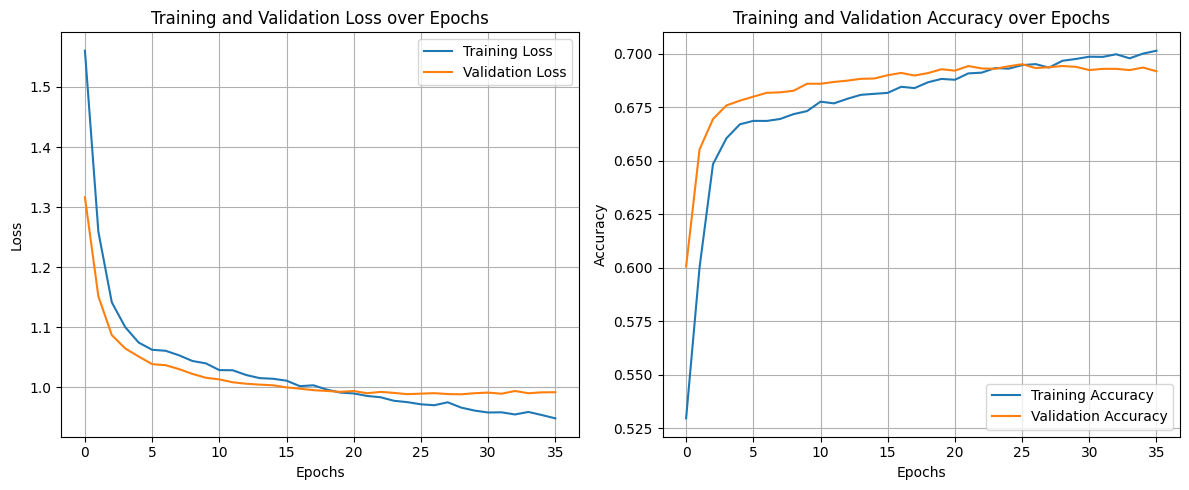

In [ ]:
# Retrieve the history dictionary
RNN1_history = RNN_history.history

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(RNN1_history['loss'], label='Training Loss')
plt.plot(RNN1_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(RNN1_history['masked_accuracy'], label='Training Accuracy')
plt.plot(RNN1_history['val_masked_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

####Visualize Bias

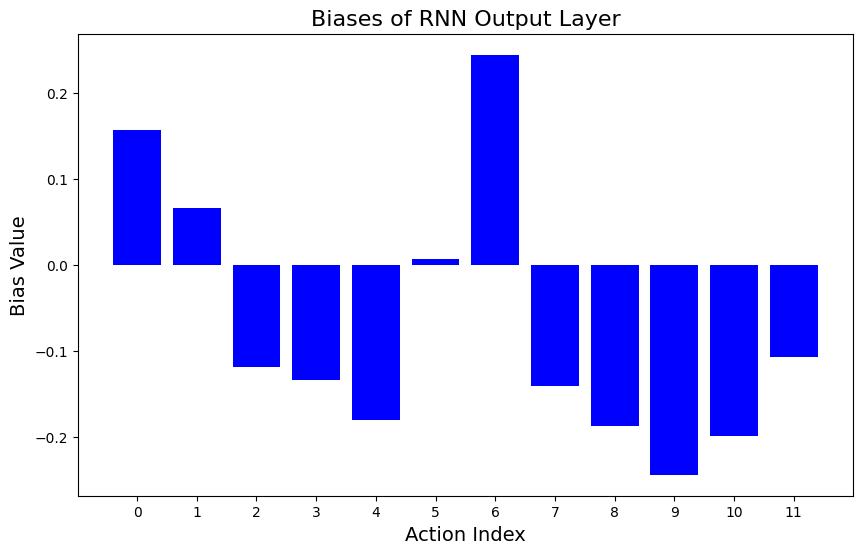

In [ ]:
# Access the Dense layer (output layer)
output_layer = RNN1.layers[-1]

# Get the biases (second element of weights)
biases = output_layer.get_weights()[1]

# Visualize biases
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(biases)), biases, color='blue')
plt.xlabel('Action Index', fontsize=14)
plt.ylabel('Bias Value', fontsize=14)
plt.title('Biases of RNN Output Layer', fontsize=16)
plt.xticks(np.arange(len(biases)), labels=np.arange(len(biases)))
plt.show()


####precision and recall

In [ ]:
RNN1.predict(RNN_sequence_val).shape

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step


(330, 704, 12)

In [ ]:
np.argmax(RNN1.predict(RNN_sequence_val), axis=-1).shape


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step


(330, 704)

In [ ]:
# Get predicted actions - the class with the highest probability for each timestep
y_pred_classes = np.argmax(RNN1.predict(RNN_sequence_val), axis=-1)  # Shape: (12779, 13)

# Flatten the arrays to calculate for each class across all timesteps
y_true_flat = RNN_target_val.flatten()  # Shape: (12779 * 13,)
y_pred_flat = y_pred_classes.flatten()  # Shape: (12779 * 13,)

precision = precision_score(y_true_flat, y_pred_flat, average=None, labels=np.arange(12))
recall = recall_score(y_true_flat, y_pred_flat, average=None, labels=np.arange(12))

print("Precision for each class (action):")
print(precision)
print("Recall for each class (action):")
print(recall)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step
Precision for each class (action):
[0.42207607 0.26916141 0.09494949 0.12880275 0.30344828 0.2772526
 0.02237611 0.05787247 0.01686341 0.06787722 0.05323741 0.05928909]
Recall for each class (action):
[0.89518664 0.66289141 0.09297725 0.29231626 0.12865497 0.59258312
 0.65279188 0.53981677 0.05988024 0.21244926 0.07974138 0.43571429]


####confusion matrix

track how often each predicted action matches the true action for each timestep in the sequence

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step


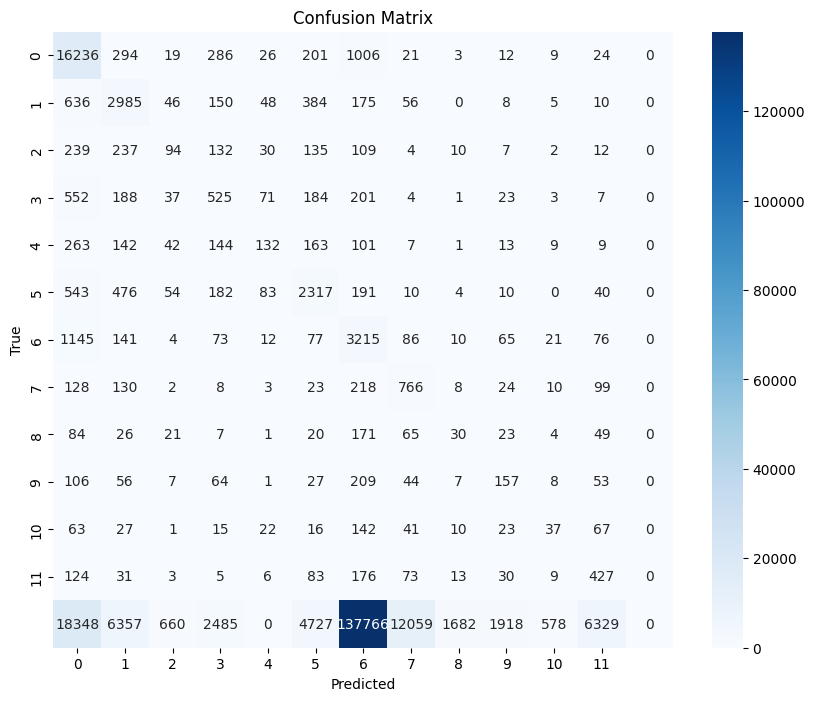

In [ ]:
#Get the predicted class (argmax along the last axis for each sequence)
predicted_classes = np.argmax(RNN1.predict(RNN_sequence_val), axis=-1)  # Shape: (12779, 13)

#Flatten the arrays to 1D
predicted_classes_flat = predicted_classes.flatten()  # Flatten to (12779 * 13)
true_classes_flat = RNN_target_val.flatten()  # Flatten to (12779 * 13)

#Compute confusion matrix
cm = confusion_matrix(true_classes_flat, predicted_classes_flat)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=np.arange(12), yticklabels=np.arange(12))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

####parameter search

manually trains multiple RNN models with different LSTM unit sizes to compare their validation accuracy

In [ ]:
# # Number of actions and max sequence length
# num_actions = 12
# max_len = 13

# # Learning rate
# learning_rate = 0.00025933707332929695

# # Hidden layer sizes (LSTM units in this case)
# hidden_layer_sizes = [2**i for i in range(3, 9)]

# # Store the results for each model configuration
# results = []



# for size in hidden_layer_sizes:
#     print(f"Training model with {size} LSTM units...")

#     # Build the RNN model with LSTM layer
#     model = Sequential([
#         Masking(mask_value=-1, input_shape=(None, 85)),  # Masking layer for padded sequences
#         LSTM(size, return_sequences=True, activation='tanh'),  # LSTM layer with variable units
#         Dense(num_actions, activation='softmax')  # Output layer for action classification
#     ])

#     # Define the optimizer
#     optimizer = Adam(learning_rate=learning_rate)

#     # Compile the model with custom loss and accuracy functions
#     model.compile(optimizer=optimizer, loss=masked_sparse_categorical_crossentropy, metrics=[masked_accuracy])

#     # Updated EarlyStopping callback to monitor val_masked_accuracy
#     # Set up early stopping with mode='max'
#     early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=5, restore_best_weights=True)

# # Train the model with early stopping
#     RNN_history = model.fit(
#         RNN_sequence_train, RNN_target_train,
#         epochs=50,
#         batch_size=32,
#         validation_data=(RNN_sequence_val, RNN_target_val),
#         callbacks=[early_stopping],
#         verbose=0
#     )

#     # Evaluate the model on the validation set
#     val_accuracy = model.evaluate(RNN_sequence_val, RNN_target_val, verbose=0)[1]
#     print(f"Validation accuracy for {size} LSTM units: {val_accuracy}")

#     # Store the result
#     results.append({'lstm_units': size, 'val_accuracy': val_accuracy})

# # Display the results
# for result in results:
#     print(f"LSTM units: {result['lstm_units']}, Validation Accuracy: {result['val_accuracy']}")


best combination of LSTM units and learning rate that maximizes validation accuracy.

In [ ]:
# import optuna


# # Define the Optuna objective function
# def objective(trial):
#     # Suggest a learning rate between 0.0001 and 0.01
#     learning_rate = trial.suggest_loguniform('learning_rate', 0.0001, 0.01)

#     # Suggest the number of LSTM units (e.g., between 32 and 256)
#     lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128, 256])

#     # Build the model
#     model = Sequential([
#         Masking(mask_value=-1, input_shape=(None, 85)),  # Input shape (None, 85 features)
#         LSTM(lstm_units, return_sequences=True, activation='tanh'),  # Use the number of LSTM units suggested by Optuna
#         Dense(num_actions, activation='softmax')  # Output layer for classification
#     ])

#     # Compile the model using the suggested learning rate
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss=masked_sparse_categorical_crossentropy, metrics=['accuracy'])

#     # Train the model
#     history = model.fit(
#         RNN_sequence_train,  # Training sequences
#         RNN_target_train,    # Training targets
#         epochs=19,           # Fixed number of epochs
#         batch_size=32,       # Fixed batch size
#         validation_split=0.2,  # 20% of data used for validation
#         verbose=0            # Suppress verbose output
#     )

#     # Get the validation accuracy of the model
#     val_accuracy = history.history['val_accuracy'][-1]  # Get the last epoch's validation accuracy

#     # Return the validation accuracy as the objective value
#     return val_accuracy

# # Create an Optuna study to maximize the validation accuracy
# study = optuna.create_study(direction='maximize')

# # Optimize the study for a given number of trials (e.g., 50 trials)
# study.optimize(objective, n_trials=50)

# # Print the best trial's parameters
# print("Best trial:")
# trial = study.best_trial
# print(f"  Value: {trial.value}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")


###ii) RNN2: 2 Hidden LSTM layers

In [ ]:
num_actions = 12
max_len = 704

# Build the LSTM model
RNN2 = Sequential([
    # Masking layer to ignore the padding (-1) in sequences
    Masking(mask_value=-1, input_shape=(None, 85)),

    # First LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Second LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Dense output layer with softmax activation for classification
    Dense(num_actions, activation='softmax')  # Output layer for predicting the next action
])


optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
# Compile the model with adam optimizer and sparse categorical crossentropy
#model2.compile(optimizer='adam', loss=masked_sparse_categorical_crossentropy, metrics=['accuracy'])
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

RNN2.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
RNN2_history = RNN2.fit(
    RNN_sequence_train,  # Padded input tensor
    RNN_target_train,    # Padded target tensor
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],  # Include the EarlyStopping callback here
    # shuffle=True  # Uncomment if you want to shuffle the training data
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 1.8195 - masked_accuracy: 0.4581 - val_loss: 1.3720 - val_masked_accuracy: 0.5741
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 1.3180 - masked_accuracy: 0.5884 - val_loss: 1.1966 - val_masked_accuracy: 0.6419
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 1.1670 - masked_accuracy: 0.6382 - val_loss: 1.1052 - val_masked_accuracy: 0.6584
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.1037 - masked_accuracy: 0.6566 - val_loss: 1.0607 - val_masked_accuracy: 0.6774
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 1.0574 - masked_accuracy: 0.6717 - val_loss: 1.0432 - val_masked_accuracy: 0.6798
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.0769 - masked_accuracy: 0.6636 - val_loss: 1.0399 - val_masked_accuracy: 0.6814
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 1.0691 - masked_accuracy: 0.6681 - val_loss: 1.0264 - val_masked_accuracy: 0.6839
Epoch 8/50
33/33 ━━━

In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = RNN2.evaluate(
    RNN_sequence_val,
    RNN_target_val,
    batch_size=32
)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - loss: 0.9785 - masked_accuracy: 0.6983
Validation Loss: 1.0087560415267944
Validation Accuracy: 0.6872931122779846


####Confusion Marix

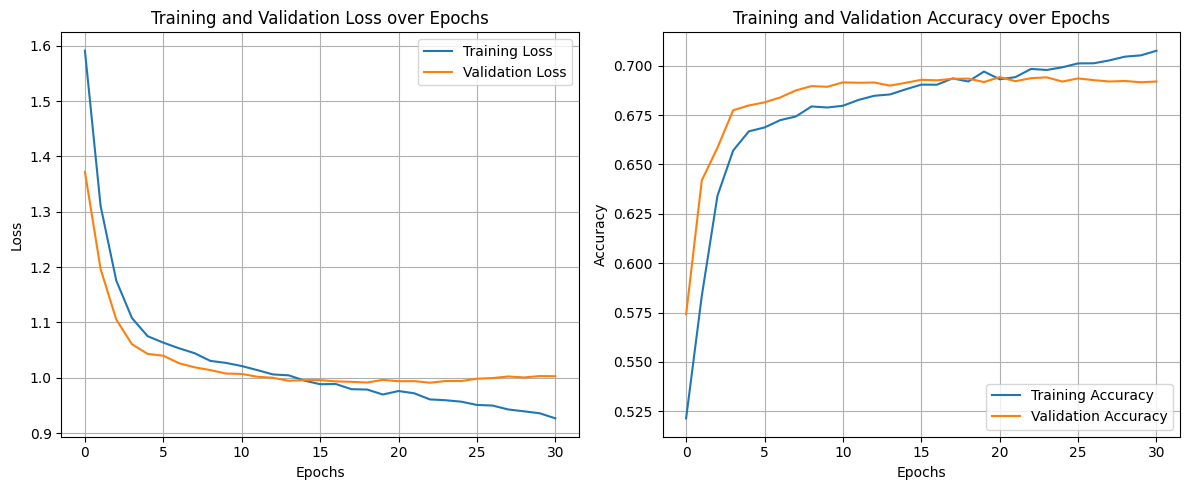

In [ ]:
# Retrieve the history dictionary
RNN2_history_dict = RNN2_history.history  # Access the history attribute

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(RNN2_history_dict['loss'], label='Training Loss')
plt.plot(RNN2_history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(RNN2_history_dict['masked_accuracy'], label='Training Accuracy')
plt.plot(RNN2_history_dict['val_masked_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


confusion matrix

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision for each class (action): [0.37977831 0.29821054 0.06290801 0.14380213 0.1028632  0.25615066
 0.02229454 0.05064137 0.01791809 0.07836991 0.04601227 0.07405971
 0.        ]
Recall for each class (action): [0.90108618 0.66244726 0.10484669 0.27839644 0.09454191 0.60179028
 0.6328934  0.534179   0.04191617 0.2368065  0.06465517 0.38979592
 0.        ]


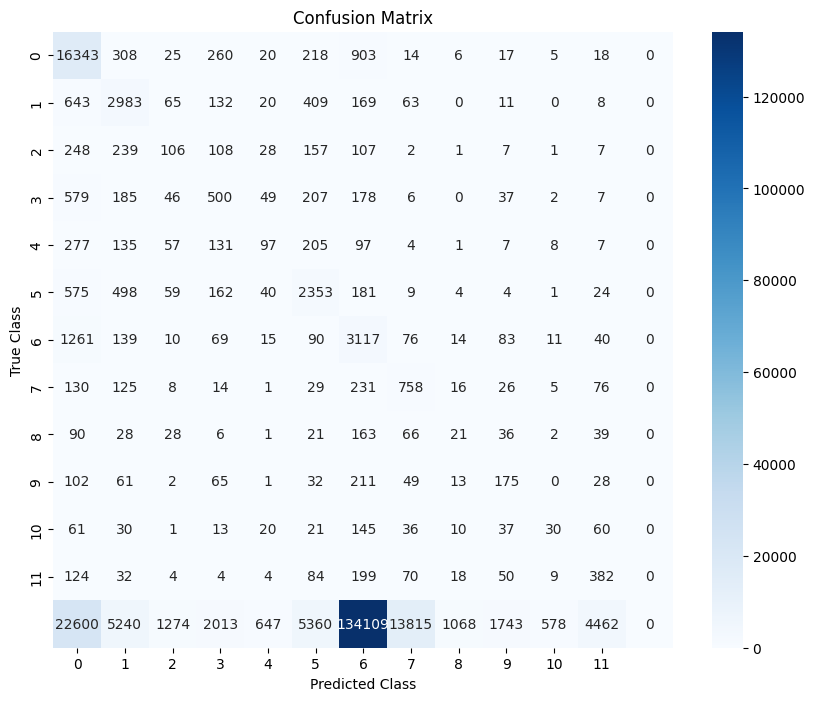

In [ ]:
# Step 1: Make predictions on the validation set
y_pred_proba = RNN2.predict(RNN_sequence_val)  # shape (num_sequences, max_len, num_actions)
y_pred = np.argmax(y_pred_proba, axis=-1)  # shape (num_sequences, max_len)

# Step 2: Flatten predictions and true labels
y_pred_flat = y_pred.flatten()
y_true_flat = RNN_target_val.flatten()

# Mask out padding values (-1) from both y_pred_flat and y_true_flat
mask = (y_true_flat != -1)
y_pred_flat = y_pred_flat[mask]
y_true_flat = y_true_flat[mask]

# Step 3: Calculate precision and recall for each class
precision = precision_score(y_true_flat, y_pred_flat, average=None)
recall = recall_score(y_true_flat, y_pred_flat, average=None)

print("Precision for each class (action):", precision)
print("Recall for each class (action):", recall)

# Step 4: Generate and display confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_actions), yticklabels=np.arange(num_actions))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


### iii) RNN3: 3 hidden LSTM layers

In [ ]:
num_actions = 12
#max_len = 704

# Build the LSTM model
RNN3 = Sequential([
    # Masking layer to ignore the padding (-1) in sequences
    Masking(mask_value=-1, input_shape=(None, 85)),

    # First LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Second LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Third LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Dense output layer with softmax activation for classification
    Dense(num_actions, activation='softmax')  # Output layer for predicting the next action
])

# Compile the model with adam optimizer and sparse categorical crossentropy
#model3.compile(optimizer='adam', loss=masked_sparse_categorical_crossentropy, metrics=['accuracy'])
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

RNN3.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
RNN3_history = RNN3.fit(
    RNN_sequence_train,  #padded input tensor
    RNN_target_train,    #padded target tensor
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    #shuffle=True
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 1.8290 - masked_accuracy: 0.4436 - val_loss: 1.4362 - val_masked_accuracy: 0.5561
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - loss: 1.4433 - masked_accuracy: 0.5423 - val_loss: 1.2663 - val_masked_accuracy: 0.5833
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - loss: 1.2685 - masked_accuracy: 0.5970 - val_loss: 1.1700 - val_masked_accuracy: 0.6395
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 1.2072 - masked_accuracy: 0.6212 - val_loss: 1.1146 - val_masked_accuracy: 0.6574
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 1.1280 - masked_accuracy: 0.6478 - val_loss: 1.0757 - val_masked_accuracy: 0.6701
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - loss: 1.0959 - masked_accuracy: 0.6571 - val_loss: 1.0545 - val_masked_accuracy: 0.6787
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 1.0677 - masked_accuracy: 0.6686 - val_loss: 1.0357 - val_masked_accuracy: 0.6808
Epoch 8/50
33/33 ━━━

In [ ]:
# Evaluate the model on validation data
val_loss, val_accuracy = RNN3.evaluate(
    RNN_sequence_val,
    RNN_target_val,
    batch_size=32
)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 315ms/step - loss: 0.9786 - masked_accuracy: 0.6983
Validation Loss: 1.0116323232650757
Validation Accuracy: 0.686757504940033


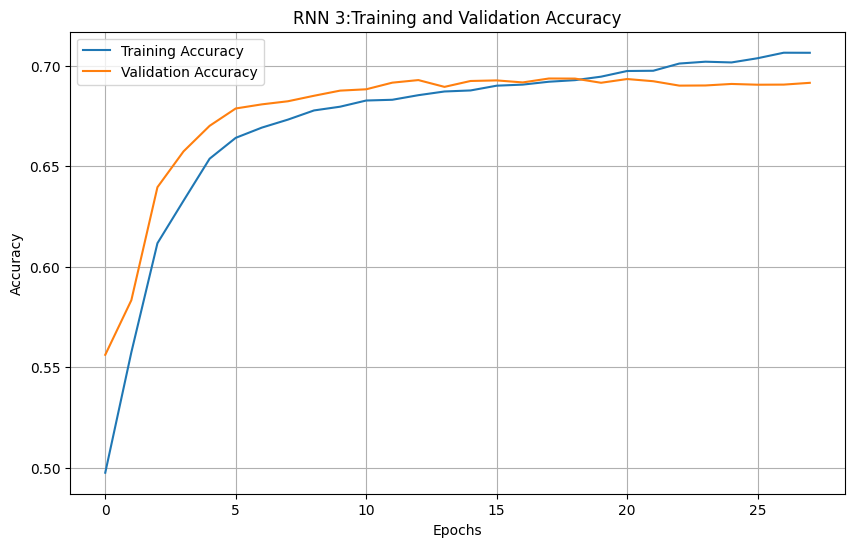

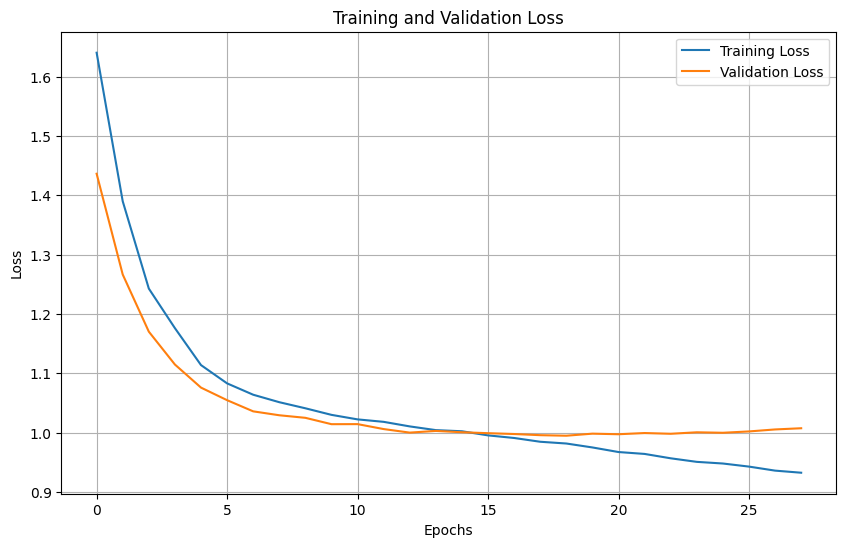

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(RNN3_history.history['masked_accuracy'], label='Training Accuracy')
plt.plot(RNN3_history.history['val_masked_accuracy'], label='Validation Accuracy')
plt.title('RNN 3:Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(RNN3_history.history['loss'], label='Training Loss')
plt.plot(RNN3_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#### confusion matrix

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step
Precision for each class (action): [0.39598955 0.28105828 0.32780083 0.13505402 0.05824647 0.32295336
 0.02268531 0.05314587 0.         0.06918043 0.03450755 0.04777
 0.        ]
Recall for each class (action): [0.90262998 0.65112147 0.07814045 0.25055679 0.09259259 0.58618926
 0.64609137 0.53276956 0.         0.30040595 0.10344828 0.44591837
 0.        ]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


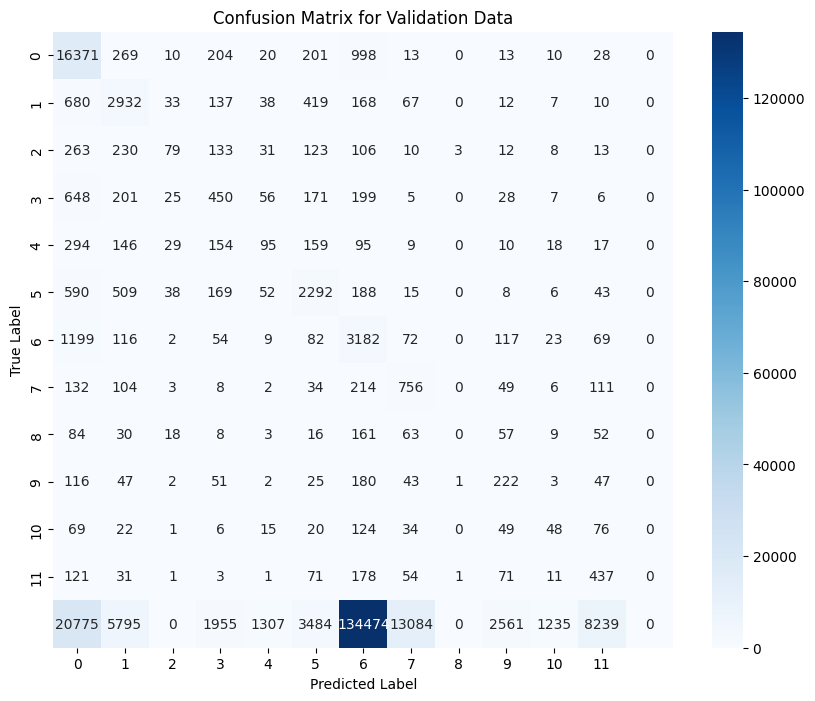

In [ ]:
# Generate predictions on the validation set
val_predictions = RNN3.predict(RNN_sequence_val)
val_predictions_classes = np.argmax(val_predictions, axis=-1)  # Predicted class for each timestep

# Flatten both predictions and true labels
val_target_flat = RNN_target_val.flatten()
val_pred_flat = val_predictions_classes.flatten()

# Filter out padding values (-1) if used
mask = val_target_flat != -1
val_target_flat = val_target_flat[mask]
val_pred_flat = val_pred_flat[mask]

#Calculate precision and recall for each class
precision = precision_score(val_target_flat, val_pred_flat, average=None)
recall = recall_score(val_target_flat, val_pred_flat, average=None)

# Print precision and recall
print("Precision for each class (action):", precision)
print("Recall for each class (action):", recall)

#Create and plot confusion matrix
conf_matrix = confusion_matrix(val_target_flat, val_pred_flat)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_actions), yticklabels=range(num_actions))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation Data')
plt.show()


##d) RNNs 1-3: Previous Action Only

In [ ]:
# Step 1: Define a function to slice the last 13 elements of each board state
def slice_and_pad_board_states(board_states, max_len, slice_len=13, pad_value=-1):
    # Slice the last `slice_len` elements of each 85-element board state array
    sliced_states = [state[-slice_len:] for state in board_states]

    # If the sequence is longer than max_len, truncate it
    if len(sliced_states) > max_len:
        sliced_states = sliced_states[:max_len]

    # Pad the sequence to match `max_len` with vectors of `pad_value` if needed
    padded_seq = sliced_states + [np.full(slice_len, pad_value)] * (max_len - len(sliced_states))

    return np.array(padded_seq)

# Step 2: Apply the slicing and padding function to each row in `final_df['board_states']`
final_df['sliced_padded_sequences'] = final_df['board_states'].apply(lambda seq: slice_and_pad_board_states(seq, max_len))

# Convert to a NumPy array for RNN input
sequence_tensor = np.stack(final_df['sliced_padded_sequences'].values)
print(sequence_tensor.shape)  # Expected shape: (number of rows, max_len, 13)


(1649, 704, 13)


In [ ]:
# Splitting the data into training and validation sets
RNN_sequence_train_13, RNN_sequence_val_13, RNN_target_train_13, RNN_target_val_13 = train_test_split(
    sequence_tensor, target_tensor, test_size=0.2, random_state=42
)

print("Training sequence shape:", RNN_sequence_train.shape)
print("Validation sequence shape:", RNN_sequence_val.shape)
print("Training target shape:", RNN_target_train.shape)
print("Validation target shape:", RNN_target_val.shape)


Training sequence shape: (1319, 704, 85)
Validation sequence shape: (330, 704, 85)
Training target shape: (1319, 704)
Validation target shape: (330, 704)


###RNN1_13

In [ ]:
num_actions = 12

# Set up the LSTM model with the modified input shape (last 13 elements of board states)
RNN1_13 = Sequential([
    # Masking layer to ignore the padding (-1) in sequences
    Masking(mask_value=-1, input_shape=(None, 13)),  # Input shape now has 13 features

    # LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Dense output layer with softmax activation for classification/predicting tbe next action
    Dense(num_actions, activation='softmax')
])

# Define the Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compile the model with the custom optimizer and loss function
RNN1_13.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

# Train the model
RNN1_13_history = RNN1_13.fit(
    RNN_sequence_train_13,  # padded input tensor with (number of rows, max_len, 13)
    RNN_target_train_13,    # padded target tensor with (number of rows, max_len)
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - loss: 1.8441 - masked_accuracy: 0.4542 - val_loss: 1.3752 - val_masked_accuracy: 0.5884
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 489ms/step - loss: 1.4071 - masked_accuracy: 0.5690 - val_loss: 1.3010 - val_masked_accuracy: 0.6054
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 488ms/step - loss: 1.3190 - masked_accuracy: 0.5926 - val_loss: 1.2628 - val_masked_accuracy: 0.6138
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 485ms/step - loss: 1.2565 - masked_accuracy: 0.6145 - val_loss: 1.2241 - val_masked_accuracy: 0.6175
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 479ms/step - loss: 1.2315 - masked_accuracy: 0.6091 - val_loss: 1.1565 - val_masked_accuracy: 0.6505
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 478ms/step - loss: 1.1822 - masked_accuracy: 0.6345 - val_loss: 1.1205 - val_masked_accuracy: 0.6556
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 485ms/step - loss: 1.1388 - masked_accuracy: 0.6423 - val_loss: 1.1061 - val_masked_accuracy: 0.6561
Epoch 8/50

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = RNN1_13.evaluate(RNN_sequence_val_13, RNN_target_val_13)

# Print the results
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 1.0080 - masked_accuracy: 0.6881
Validation Loss: 1.0400108098983765
Validation Accuracy: 0.6760698556900024


In [ ]:
# import numpy as np
# from sklearn.metrics import precision_score, recall_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Step 1: Generate predictions on the validation set
# val_predictions = RNN1_13.predict(RNN_sequence_val_13)
# val_predictions_classes = np.argmax(val_predictions, axis=-1)  # Predicted class for each timestep

# # Step 2: Flatten predictions and true labels
# val_target_flat = RNN_target_val.flatten()
# val_pred_flat = val_predictions_classes.flatten()

# # Step 3: Filter out padding values (-1) in both true and predicted labels
# mask = val_target_flat != -1
# val_target_flat = val_target_flat[mask]
# val_pred_flat = val_pred_flat[mask]

# # Step 4: Calculate precision and recall for each class
# precision = precision_score(val_target_flat, val_pred_flat, average=None)
# recall = recall_score(val_target_flat, val_pred_flat, average=None)

# # Print precision and recall for each action class
# print("Precision for each class (action):", precision)
# print("Recall for each class (action):", recall)

# # Step 5: Generate and plot the confusion matrix
# conf_matrix = confusion_matrix(val_target_flat, val_pred_flat)

# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#             xticklabels=range(num_actions), yticklabels=range(num_actions))
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix for Validation Data')
# plt.show()


###RNN2_13

In [ ]:
num_actions = 12

# Set up the LSTM model with the modified input shape (last 13 elements of board states)
RNN2_13 = Sequential([
    # Masking layer to ignore the padding (-1) in your sequences
    Masking(mask_value=-1, input_shape=(None, 13)),  # 85 is the number of features (dims in input tensor)

    # First LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Second LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Dense output layer with softmax activation for classification/predicting the next action
    Dense(num_actions, activation='softmax')
])


optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
# Compile the model with adam optimizer and sparse categorical crossentropy
#model2.compile(optimizer='adam', loss=masked_sparse_categorical_crossentropy, metrics=['accuracy'])
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

RNN2_13.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the model
RNN2_13_history = RNN2_13.fit(
    RNN_sequence_train_13,  # padded input tensor with (number of rows, max_len, 13)
    RNN_target_train_13,    # padded target tensor with (number of rows, max_len)
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.7703 - masked_accuracy: 0.4671 - val_loss: 1.3978 - val_masked_accuracy: 0.5692
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 1.3929 - masked_accuracy: 0.5713 - val_loss: 1.2956 - val_masked_accuracy: 0.6042
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 1.3238 - masked_accuracy: 0.5884 - val_loss: 1.2552 - val_masked_accuracy: 0.6159
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 1.2548 - masked_accuracy: 0.6055 - val_loss: 1.1794 - val_masked_accuracy: 0.6434
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.1428 - masked_accuracy: 0.6445 - val_loss: 1.1309 - val_masked_accuracy: 0.6550
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.1617 - masked_accuracy: 0.6384 - val_loss: 1.1111 - val_masked_accuracy: 0.6563
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.1118 - masked_accuracy: 0.6549 - val_loss: 1.0871 - val_masked_accuracy: 0.6628
Epoch 8/50
33/33 ━━━

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = RNN2_13.evaluate(RNN_sequence_val_13, RNN_target_val_13)

# Print the results
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 1.0142 - masked_accuracy: 0.6880
Validation Loss: 1.0466183423995972
Validation Accuracy: 0.6764447689056396


###RNN3_13

In [ ]:
num_actions = 12
max_len = 704

# Build the LSTM model
RNN3_13 = Sequential([
    # Masking layer to ignore the padding (-1) in sequences
    Masking(mask_value=-1, input_shape=(None, 13)),  # 85 is the number of features (dims in input tensor)

    # First LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Second LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Third LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    # Dense output layer with softmax activation for classification/predicting the next action
    Dense(num_actions, activation='softmax')
])

# Compile the model with adam optimizer and sparse categorical crossentropy
#model3.compile(optimizer='adam', loss=masked_sparse_categorical_crossentropy, metrics=['accuracy'])
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

RNN3_13.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
RNN3_13_history = RNN3_13.fit(
    RNN_sequence_train_13,  #padded input tensor
    RNN_target_train_13,    #padded target tensor
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    #shuffle=True
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - loss: 1.8829 - masked_accuracy: 0.4532 - val_loss: 1.4466 - val_masked_accuracy: 0.5560
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 1.4439 - masked_accuracy: 0.5483 - val_loss: 1.3726 - val_masked_accuracy: 0.5734
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 1.3713 - masked_accuracy: 0.5702 - val_loss: 1.2902 - val_masked_accuracy: 0.6053
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 1.2981 - masked_accuracy: 0.5923 - val_loss: 1.2471 - val_masked_accuracy: 0.6157
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 1.2386 - masked_accuracy: 0.6077 - val_loss: 1.1833 - val_masked_accuracy: 0.6173
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 1.1843 - masked_accuracy: 0.6304 - val_loss: 1.1248 - val_masked_accuracy: 0.6568
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - loss: 1.1519 - masked_accuracy: 0.6401 - val_loss: 1.1122 - val_masked_accuracy: 0.6596
Epoch 8/50
33/33 ━━━

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = RNN3_13.evaluate(RNN_sequence_val_13, RNN_target_val_13)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - loss: 1.0114 - masked_accuracy: 0.6872
Validation Loss: 1.0435999631881714
Validation Accuracy: 0.6758388876914978


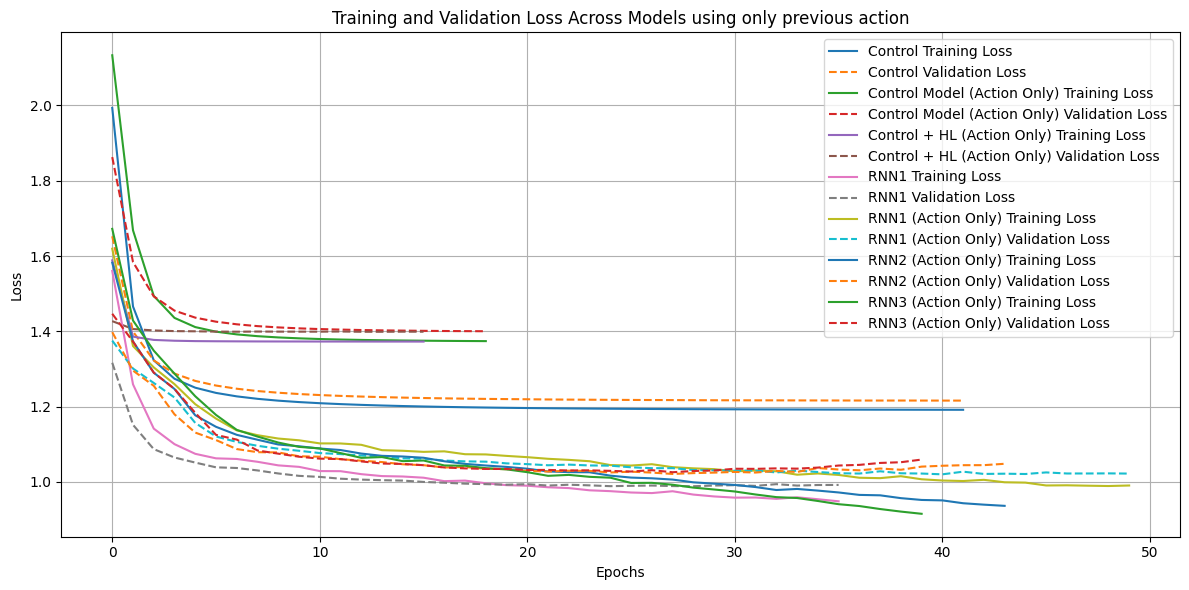

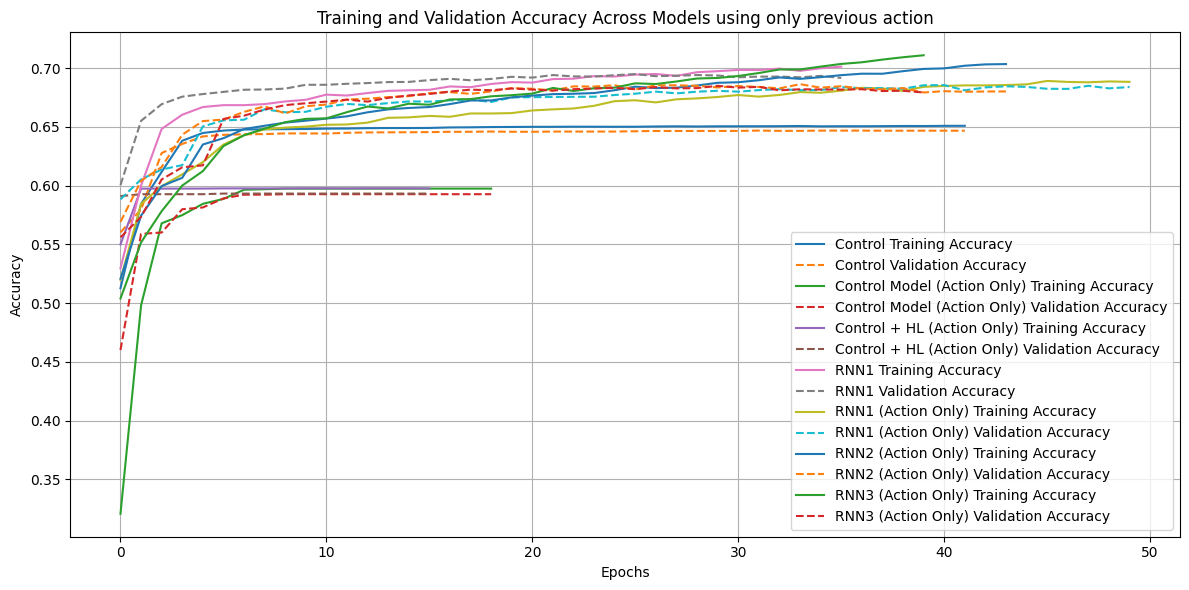

In [ ]:
# Ensure all histories are in dictionary form
histories = {
    "Control": glm_history.history,
    "Control Model (Action Only)": control1_history.history,
    "Control + HL (Action Only)": history_control3_13.history,
    "RNN1": RNN_history.history,
    "RNN1 (Action Only)": RNN1_13_history.history,
    "RNN2 (Action Only)": RNN2_13_history.history,
    "RNN3 (Action Only)": RNN3_13_history.history,
}

#Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
for model_name, history in histories.items():
    plt.plot(history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history['val_loss'], linestyle='--', label=f'{model_name} Validation Loss')
plt.title('Training and Validation Loss Across Models using only previous action')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
for model_name, history in histories.items():
    if "masked_accuracy" in history:  # For RNN models
        plt.plot(history['masked_accuracy'], label=f'{model_name} Training Accuracy')
        plt.plot(history['val_masked_accuracy'], linestyle='--', label=f'{model_name} Validation Accuracy')
    else:  # For GLM and Control Models
        plt.plot(history['accuracy'], label=f'{model_name} Training Accuracy')
        plt.plot(history['val_accuracy'], linestyle='--', label=f'{model_name} Validation Accuracy')
plt.title('Training and Validation Accuracy Across Models using only previous action')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


##e) RNNs 1-3: Boardstate only

In [ ]:
max_len = 704
# Step 1: Define a function to slice the first 72 elements of each board state
def slice_and_pad_board_states(board_states, max_len, slice_len=72, pad_value=-1):
    # Slice the first `slice_len` elements of each 85-element board state array
    sliced_states = [state[:slice_len] for state in board_states]

    # If the sequence is longer than max_len, truncate it
    if len(sliced_states) > max_len:
        sliced_states = sliced_states[:max_len]

    # Pad the sequence to match `max_len` with vectors of `pad_value` if needed
    padded_seq = sliced_states + [np.full(slice_len, pad_value)] * (max_len - len(sliced_states))

    return np.array(padded_seq)

# Step 2: Apply the slicing and padding function to each row in `final_df['board_states']`
final_df['sliced_padded_sequences'] = final_df['board_states'].apply(lambda seq: slice_and_pad_board_states(seq, max_len))

# Convert to a NumPy array for RNN input
sequence_tensor = np.stack(final_df['sliced_padded_sequences'].values)
print(sequence_tensor.shape)  # Expected shape: (number of rows, max_len, 72)


(1649, 704, 72)


In [ ]:
# Splitting the data into training and validation sets
RNN_sequence_train_72, RNN_sequence_val_72, RNN_target_train_72, RNN_target_val_72 = train_test_split(
    sequence_tensor, target_tensor, test_size=0.2, random_state=42
)

###RNN1_72

In [ ]:
# Define the padding mask value (-1 for sequences, 12 for actions)
mask_value_seq = -1  # Used for sequence masking
num_actions = 12     # Used for action classes


# Set up the LSTM model with the modified input shape (first 72 elements of game state)
RNN1_72 = Sequential([
    # Masking layer to ignore the padding (-1) in your sequences
    Masking(mask_value=mask_value_seq, input_shape=(None, 72)),  # Input shape now has 72 features

    # LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),  # Adjust units and activation as needed

    # Dense output layer with softmax activation for classification
    Dense(num_actions, activation='softmax')  # Output layer for predicting the next action
])

# Define the Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compile the model with the custom optimizer and loss function
RNN1_72.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

# Train the model
RNN_72_history = RNN1_72.fit(
    RNN_sequence_train_72,  # padded input tensor with (number of rows, max_len, 72)
    RNN_target_train_72,    # padded target tensor with (number of rows, max_len)
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 537ms/step - loss: 1.9572 - masked_accuracy: 0.4621 - val_loss: 1.4683 - val_masked_accuracy: 0.5356
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 527ms/step - loss: 1.4766 - masked_accuracy: 0.5304 - val_loss: 1.3560 - val_masked_accuracy: 0.5527
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 529ms/step - loss: 1.3752 - masked_accuracy: 0.5518 - val_loss: 1.2631 - val_masked_accuracy: 0.6012
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 534ms/step - loss: 1.2644 - masked_accuracy: 0.6023 - val_loss: 1.2290 - val_masked_accuracy: 0.6132
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 531ms/step - loss: 1.2582 - masked_accuracy: 0.6048 - val_loss: 1.2014 - val_masked_accuracy: 0.6264
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 534ms/step - loss: 1.2311 - masked_accuracy: 0.6102 - val_loss: 1.1820 - val_masked_accuracy: 0.6265
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 536ms/step - loss: 1.2089 - masked_accuracy: 0.6154 - val_loss: 1.1781 - val_masked_accuracy: 0.6269

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = RNN1_72.evaluate(RNN_sequence_val_72, RNN_target_val_72)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 1.0577 - masked_accuracy: 0.6748
Validation Loss: 1.087891697883606
Validation Accuracy: 0.6655576825141907


In [ ]:
# import numpy as np
# from sklearn.metrics import precision_score, recall_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Step 1: Generate predictions on the validation set
# val_predictions = RNN1_72.predict(RNN_sequence_val)
# val_predictions_classes = np.argmax(val_predictions, axis=-1)  # Predicted class for each timestep

# # Step 2: Flatten predictions and true labels
# val_target_flat = RNN_target_val.flatten()
# val_pred_flat = val_predictions_classes.flatten()

# # Step 3: Filter out padding values (-1) in both true and predicted labels
# mask = val_target_flat != -1
# val_target_flat = val_target_flat[mask]
# val_pred_flat = val_pred_flat[mask]

# # Step 4: Calculate precision and recall for each class
# precision = precision_score(val_target_flat, val_pred_flat, average=None)
# recall = recall_score(val_target_flat, val_pred_flat, average=None)

# # Print precision and recall for each action class
# print("Precision for each class (action):", precision)
# print("Recall for each class (action):", recall)

# # Step 5: Generate and plot the confusion matrix
# conf_matrix = confusion_matrix(val_target_flat, val_pred_flat)

# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
#             xticklabels=range(num_actions), yticklabels=range(num_actions))
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix for Validation Data')
# plt.show()


###RNN2_72

In [ ]:
# Define the padding mask value (-1 for sequences, 12 for actions)
mask_value_seq = -1  # Used for sequence masking
num_actions = 12     # Used for action classes


# Set up the LSTM model with the modified input shape (first 72 elements of game state)
RNN2_72 = Sequential([
    # Masking layer to ignore the padding (-1) in your sequences
    Masking(mask_value=mask_value_seq, input_shape=(None, 72)),  # Input shape now has 72 features

    # LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    LSTM(64, return_sequences=True, activation='tanh'),

    # Dense output layer with softmax activation for classification
    Dense(num_actions, activation='softmax')  # Output layer for predicting the next action
])

# Define the Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compile the model with the custom optimizer and loss function
RNN2_72.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

# Training the model
RNN2_72_history = RNN2_72.fit(
    RNN_sequence_train_72,  # padded input tensor with (number of rows, max_len, 72)
    RNN_target_train_72,    # padded target tensor with (number of rows, max_len)
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=True
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 1.9749 - masked_accuracy: 0.4271 - val_loss: 1.5202 - val_masked_accuracy: 0.5268
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 1.5351 - masked_accuracy: 0.5115 - val_loss: 1.4030 - val_masked_accuracy: 0.5428
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.3962 - masked_accuracy: 0.5393 - val_loss: 1.2842 - val_masked_accuracy: 0.5937
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 1.2753 - masked_accuracy: 0.5927 - val_loss: 1.2287 - val_masked_accuracy: 0.6165
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 1.2256 - masked_accuracy: 0.6151 - val_loss: 1.1939 - val_masked_accuracy: 0.6257
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.2200 - masked_accuracy: 0.6163 - val_loss: 1.1821 - val_masked_accuracy: 0.6310
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 1.1810 - masked_accuracy: 0.6258 - val_loss: 1.1587 - val_masked_accuracy: 0.6413
Epoch 8/50
33/33 ━━━

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = RNN2_72.evaluate(RNN_sequence_val_72, RNN_target_val_72)

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 1.0630 - masked_accuracy: 0.6781
Validation Loss: 1.0970146656036377
Validation Accuracy: 0.6695287227630615


###RNN3_72

In [ ]:
# Define the padding mask value (-1 for sequences, 12 for actions)
mask_value_seq = -1  # Used for sequence masking
num_actions = 12     # Used for action classes


# Set up the LSTM model with the modified input shape (first 72 elements of game state)
RNN3_72 = Sequential([
    # Masking layer to ignore the padding (-1) in your sequences
    Masking(mask_value=mask_value_seq, input_shape=(None, 72)),  # Input shape now has 72 features

    # LSTM layer
    LSTM(64, return_sequences=True, activation='tanh'),

    LSTM(64, return_sequences=True, activation='tanh'),

    LSTM(64, return_sequences=True, activation='tanh'),

    # Dense output layer with softmax activation for classification
    Dense(num_actions, activation='softmax')  # Output layer for predicting the next action
])

# Define the Adam optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compile the model with the custom optimizer and loss function
RNN3_72.compile(
    optimizer=optimizer,
    loss=masked_sparse_categorical_crossentropy,
    metrics=[masked_accuracy]
)

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', patience=10, restore_best_weights=True)

# Train the model
RNN3_72_history = RNN3_72.fit(
    RNN_sequence_train_72,  # padded input tensor with (number of rows, max_len, 72)
    RNN_target_train_72,    # padded target tensor with (number of rows, max_len)
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - loss: 1.9377 - masked_accuracy: 0.4352 - val_loss: 1.5579 - val_masked_accuracy: 0.5136
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 1.5809 - masked_accuracy: 0.4963 - val_loss: 1.4605 - val_masked_accuracy: 0.5367
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - loss: 1.4535 - masked_accuracy: 0.5296 - val_loss: 1.3433 - val_masked_accuracy: 0.5800
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 1.3359 - masked_accuracy: 0.5704 - val_loss: 1.2693 - val_masked_accuracy: 0.5995
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - loss: 1.3231 - masked_accuracy: 0.5790 - val_loss: 1.2358 - val_masked_accuracy: 0.6061
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 1.2273 - masked_accuracy: 0.6072 - val_loss: 1.2011 - val_masked_accuracy: 0.6166
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - loss: 1.2156 - masked_accuracy: 0.6164 - val_loss: 1.1635 - val_masked_accuracy: 0.6327
Epoch 8/50
33/33 ━━━

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = RNN3_72.evaluate(RNN_sequence_val_72, RNN_target_val_72)

# Print the results
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 491ms/step - loss: 1.0622 - masked_accuracy: 0.6731
Validation Loss: 1.100069522857666
Validation Accuracy: 0.662224292755127


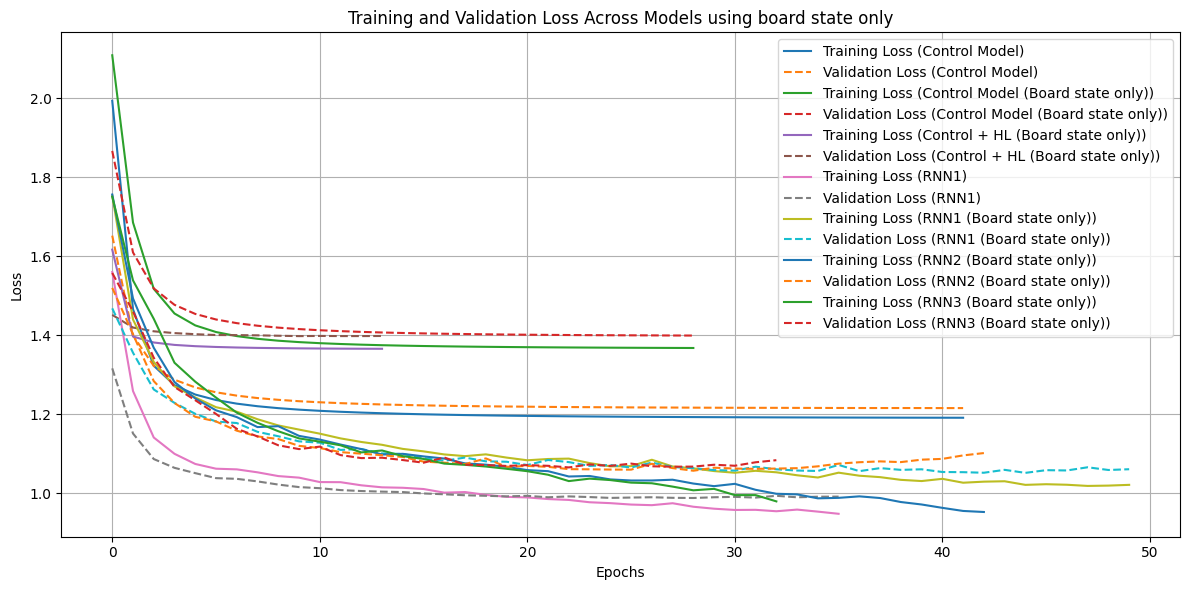

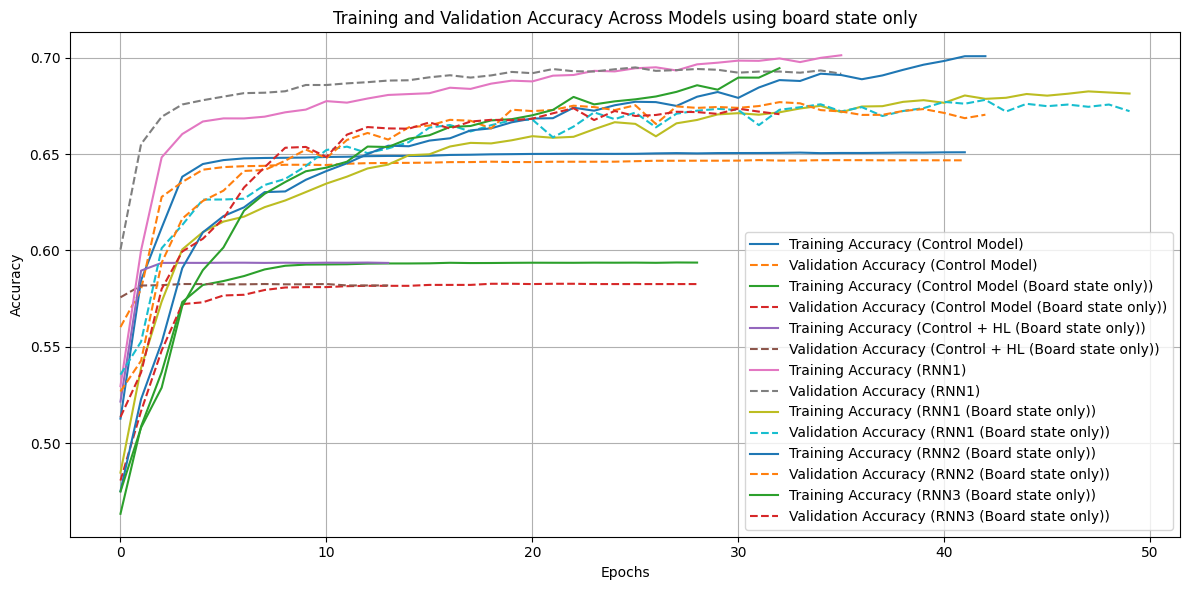

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Retrieve histories for all models
histories = {
    "Control Model": glm_history.history,
    "Control Model (Board state only)": history_control2.history,
    "Control + HL (Board state only)": history_control3_72.history,
    "RNN1": RNN_history.history,
    "RNN1 (Board state only)": RNN_72_history.history,
    "RNN2 (Board state only)": RNN2_72_history.history,
    "RNN3 (Board state only)": RNN3_72_history.history,
}

# Step 2: Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
for model_name, history in histories.items():
    plt.plot(history['loss'], label=f'Training Loss ({model_name})')
    plt.plot(history['val_loss'], linestyle='--', label=f'Validation Loss ({model_name})')
plt.title('Training and Validation Loss Across Models using board state only')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 3: Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
for model_name, history in histories.items():
    if "RNN" in model_name:  # Use masked_accuracy for RNNs
        plt.plot(history['masked_accuracy'], label=f'Training Accuracy ({model_name})')
        plt.plot(history['val_masked_accuracy'], linestyle='--', label=f'Validation Accuracy ({model_name})')
    else:  # Use standard accuracy for other models
        plt.plot(history['accuracy'], label=f'Training Accuracy ({model_name})')
        plt.plot(history['val_accuracy'], linestyle='--', label=f'Validation Accuracy ({model_name})')
plt.title('Training and Validation Accuracy Across Models using board state only')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()
